In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import zscore

In [2]:
df = pd.read_csv('train.csv', index_col=0)

In [3]:
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,...,5.0,A,A,A,A,A,A,A,B,D
2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,...,NaN,A,A,C,A,B,A,A,C,A
3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,...,NaN,A,A,A,A,C,A,A,B,A
4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,...,5.0,C,A,A,A,A,D,A,A,A
5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,...,NaN,A,A,A,A,A,A,A,A,A


In [4]:
df.shape

(13730, 166)

# Primeiro vamos realizar uma análise exploratória dos dados, para compreender algumas questões.
    - Como estão distribuídas as notas por estado? 
    - As notas de quem fez a prova de língua estrangeira em inglês é maior em relação à quem fez em espanhol? 
    - A escolaridade dos pais do candidato influeciam na nota do candidato?
    - Como estão distribuídas as notas dos candidatos em função da renda mensal familiar? 

In [5]:
df_notas_estado = df[['SG_UF_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']]
df_notas_estado.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
count,10341.000000,10341.000000,10133.000000,10133.000000
mean,473.495155,529.661087,516.472841,482.497928
std,71.093674,73.726344,68.688190,99.826323
min,0.000000,0.000000,0.000000,0.000000
25%,419.900000,480.400000,468.100000,408.900000
50%,459.800000,532.000000,520.900000,461.200000
75%,514.500000,581.200000,564.900000,537.600000
max,806.400000,807.000000,763.600000,952.000000


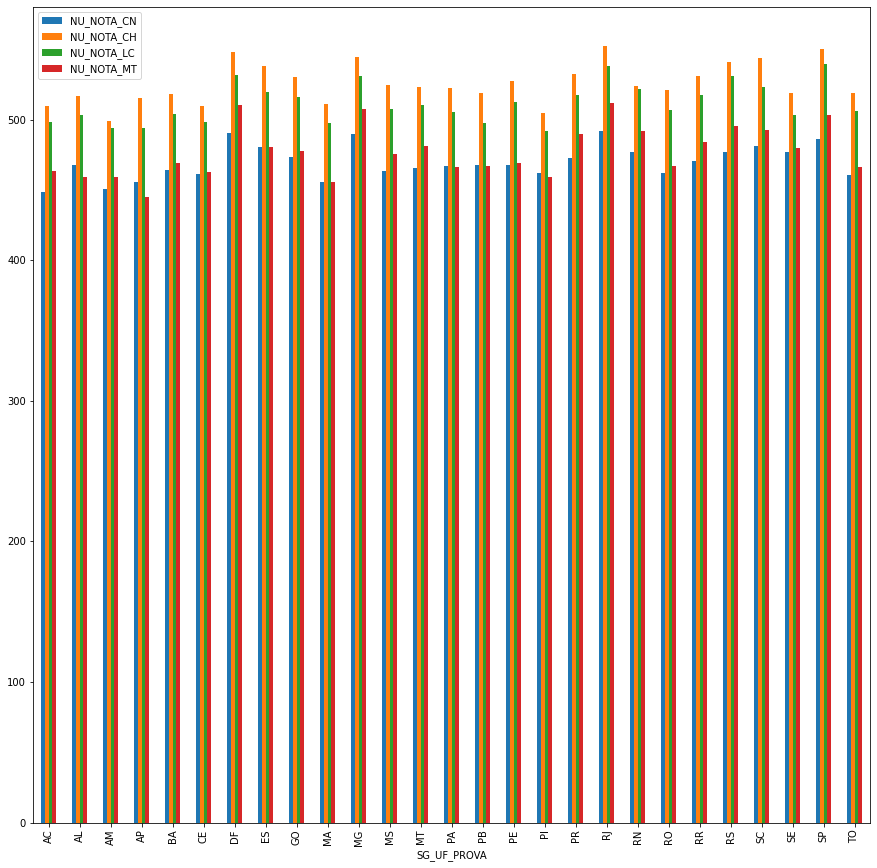

In [6]:
df_notas_estado.groupby('SG_UF_PROVA').mean().plot(kind='bar', figsize=(15, 15))

In [7]:
# Olhando para o gráfico sem levar em conta os valores NaN
df_notas_estado.dropna().describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
count,10097.000000,10097.000000,10097.000000,10097.000000
mean,473.912509,530.346123,516.665059,482.648638
std,71.098468,73.528309,68.442602,99.685820
min,0.000000,0.000000,0.000000,0.000000
25%,420.100000,481.000000,468.600000,409.000000
50%,460.400000,532.600000,521.100000,461.300000
75%,515.100000,581.900000,564.900000,537.700000
max,806.400000,807.000000,763.600000,952.000000


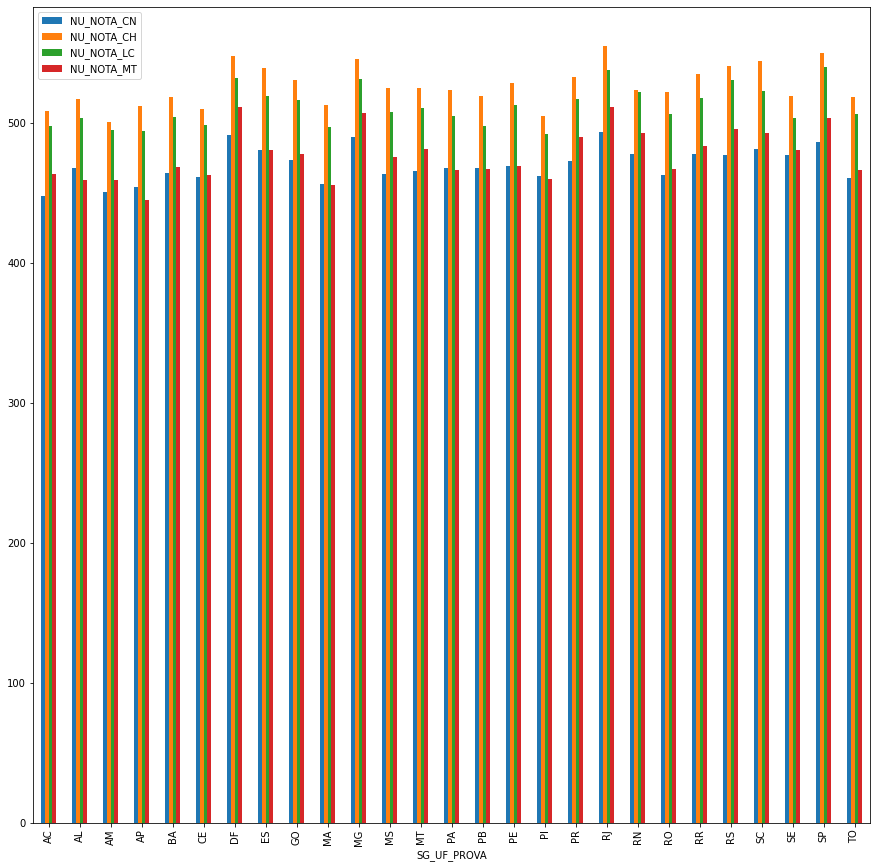

In [8]:
df_notas_estado.dropna().groupby('SG_UF_PROVA').mean().plot(kind='bar', figsize=(15, 15))

Levando em conta as informações como média, desvio padrão e os gráficos acima é plausível assumir que as notas médias por estado não variam entre si. 

In [9]:
df_notas_lingua = df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA']].copy()
df_notas_lingua.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA
count,10341.000000,10341.000000,10133.000000,10133.000000,13730.000000
mean,473.495155,529.661087,516.472841,482.497928,0.593664
std,71.093674,73.726344,68.688190,99.826323,0.491167
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.900000,480.400000,468.100000,408.900000,0.000000
50%,459.800000,532.000000,520.900000,461.200000,1.000000
75%,514.500000,581.200000,564.900000,537.600000,1.000000
max,806.400000,807.000000,763.600000,952.000000,1.000000


In [10]:
df_notas_lingua['TP_LINGUA'] = df_notas_lingua.loc[:, ('TP_LINGUA')].map({0: 'Inglês', 1: 'Espanhol'})

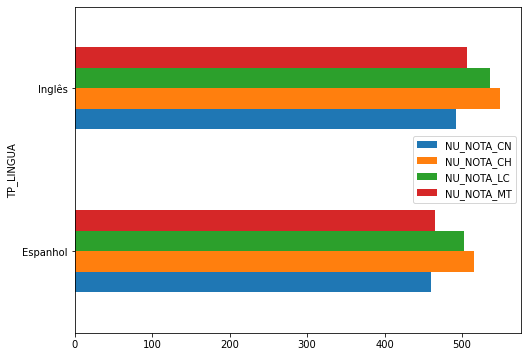

In [11]:
df_notas_lingua.groupby('TP_LINGUA').mean().plot(kind='barh', figsize=(8,6))

In [12]:
# As notas dos candidatos com prova de língua estrangeira em inglês é ligeiramente maior em todas as áreas da prova
(1 - (df_notas_lingua.groupby('TP_LINGUA').mean().iloc[0] / df_notas_lingua.groupby('TP_LINGUA').mean().iloc[1]))

NU_NOTA_CN    0.063860
NU_NOTA_CH    0.059747
NU_NOTA_LC    0.061553
NU_NOTA_MT    0.080587
dtype: float64

Agora vamos verificar as notas pela renda familiar

In [14]:
df_notas_renda = df[['Q003', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']]
df_notas_renda

,Q003,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
1,B,436.3,495.4,581.2,399.4
2,A,474.5,544.1,599.0,459.8
3,B,NaN,NaN,NaN,NaN
4,D,NaN,NaN,NaN,NaN
5,C,NaN,NaN,NaN,NaN
...,...,...,...,...,...
4582,B,438.2,419.7,394.5,403.2
4583,A,423.8,557.9,533.0,452.4
4584,B,460.5,528.9,569.3,398.0
4585,C,422.5,621.7,569.0,386.6


In [15]:
df_notas_renda.loc[:, ('Q003')].value_counts()

A    3342
C    3324
B    2826
D    1982
F    1781
E     475
Name: Q003, dtype: int64

In [16]:
enconding_renda = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [17]:
df_notas_renda.loc[:, ('Q003')].replace(enconding_renda, inplace=True)

/home/guilherme/anaconda3/envs/aceleradev-ds/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [18]:
df_notas_renda

,Q003,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
1,1,436.3,495.4,581.2,399.4
2,0,474.5,544.1,599.0,459.8
3,1,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN
5,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...
4582,1,438.2,419.7,394.5,403.2
4583,0,423.8,557.9,533.0,452.4
4584,1,460.5,528.9,569.3,398.0
4585,2,422.5,621.7,569.0,386.6


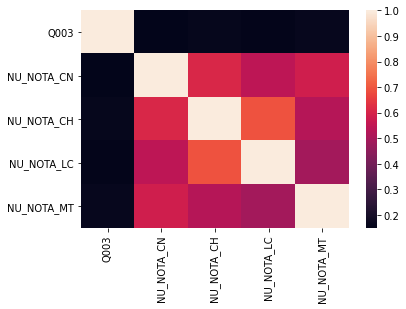

In [19]:
sns.heatmap(df_notas_renda.corr())

In [ ]:
len(df.columns)

In [ ]:
def print_heatmap_null():
    plt.figure(figsize=(20, 10))
    sns.heatmap(df.isnull(), cbar=False)
    
print_heatmap_null()

In [ ]:
# Vamos dropar colunas que possuem mais de 50% de nulos
cols_nan_values = []
for col in df.columns:
    if df[col].isnull().sum() / len(df[col]) > 0.5:
        cols_nan_values.append(col)
df.drop(cols_nan_values, axis=1, inplace=True)

In [ ]:
print_heatmap_null()

In [ ]:
cols_object_type = []
cols_number_type = []
for col in df.columns:
    if df[col].dtypes == 'object':
        cols_object_type.append(col)
    else: 
        cols_number_type.append(col)

In [ ]:
print("Qtde colunas do tipo object: " + str(len(cols_object_type)) + "\nQtde colunas do tipo numerica: " + str(len(cols_number_type)))

In [ ]:
['NU_INSCRICAO', 'NO_MUNICIPIO_RESIDENCIA', 'TP_SEXO', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO']
cols_object_type